**PS01: AI-Based Grey Market & Illegal Product Sales Detection**

**Objective**: This notebook demonstrates the preprocessing and exploratory data analysis (EDA) phase for detecting unauthorized "Grey Market" sales. We utilize real-world transactional data to engineer features that highlight price erosion and geographic distribution anomalies.

**Key Metrics**:

**PVI (Price Variance Index)**: Deviation from the market median price.

**Revenue at Risk**: Financial impact of unauthorized discounting.

In [ ]:
pip install ucimlrepo

In [ ]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

print("Downloading real-world retail dataset from UCI...")
online_retail_ii = fetch_ucirepo(id=352)

df = online_retail_ii.data.features

print("\nDataset loaded successfully!")
print(f"Total Transactions: {len(df)}")
print(df.head())

df.to_csv("real_world_retail_data.csv", index=False)


Dataset loaded successfully!
Total Transactions: 541909
                           Description  Quantity     InvoiceDate  UnitPrice  \
0   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26       2.55   
1                  WHITE METAL LANTERN         6  12/1/2010 8:26       3.39   
2       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26       2.75   
3  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26       3.39   
4       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26       3.39   

   CustomerID         Country  
0     17850.0  United Kingdom  
1     17850.0  United Kingdom  
2     17850.0  United Kingdom  
3     17850.0  United Kingdom  
4     17850.0  United Kingdom  


In [ ]:
import pandas as pd
import numpy as np

# Load the raw UCI data
df = pd.read_csv("real_world_retail_data.csv")

# 1. REMOVE NOISE: Returns (negative quantity) and rows without CustomerIDs
df_clean = df.dropna(subset=['CustomerID'])
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# 2. STANDARDIZE: Descriptions to uppercase for consistency
df_clean['Description'] = df_clean['Description'].str.strip().str.upper()

# 3. FEATURE ENGINEERING: Calculate Market MSRP (Median Price)
# We use median to avoid being skewed by the very fraudsters we want to catch
msrp_lookup = df_clean.groupby('Description')['UnitPrice'].median().reset_index()
msrp_lookup.columns = ['Description', 'MSRP']

# 4. MERGE & CALCULATE ANOMALY FEATURES
df_final = pd.merge(df_clean, msrp_lookup, on='Description')

# Price Gap: How much cheaper is this listing than the average?
df_final['Price_Gap_Percentage'] = ((df_final['MSRP'] - df_final['UnitPrice']) / df_final['MSRP']) * 100

# Revenue at Risk: If this is Grey Market, how much is the brand losing?
df_final['Revenue_At_Risk'] = (df_final['MSRP'] - df_final['UnitPrice']) * df_final['Quantity']

df_final.to_csv("cleaned_grey_market_data.csv", index=False)
print("Preprocessing complete! 'cleaned_grey_market_data.csv' created.")

Preprocessing complete! 'cleaned_grey_market_data.csv' created.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = pd.read_csv("cleaned_grey_market_data.csv")


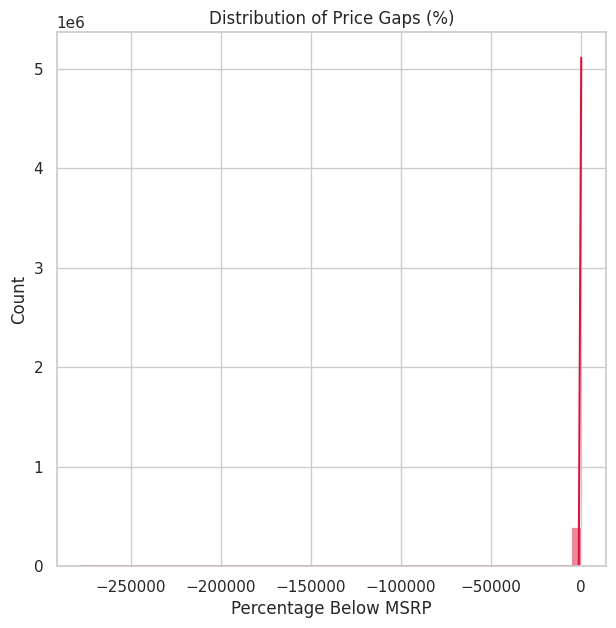

In [ ]:
# VIZ 1: Price Gap Distribution (The Anomaly "Tail")
sns.set(style="whitegrid")
plt.figure(figsize=(12, 18))
plt.subplot(3, 2, 1)

sns.histplot(df_viz['Price_Gap_Percentage'], bins=50, color='crimson', kde=True)
plt.title("Distribution of Price Gaps (%)")
plt.xlabel("Percentage Below MSRP")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Top 10 Countries by Price Erosion')

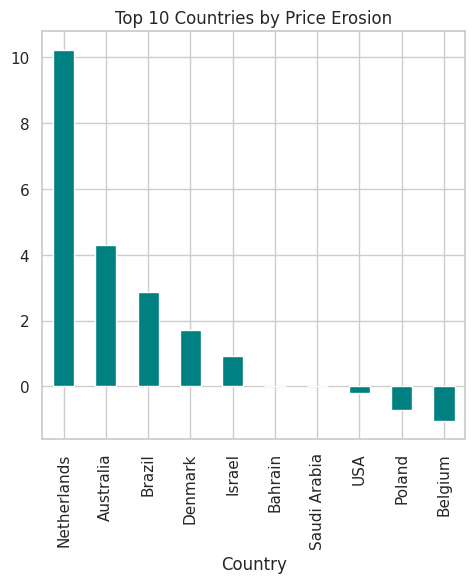

In [ ]:
# VIZ 2: High-Risk Countries (Where is the leak?)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 18))

plt.subplot(3, 2, 2)
country_risk = df_viz.groupby('Country')['Price_Gap_Percentage'].mean().sort_values(ascending=False).head(10)
country_risk.plot(kind='bar', color='teal')
plt.title("Top 10 Countries by Price Erosion")

Text(0.5, 1.0, 'Bulk Sales vs. Price Discounting')

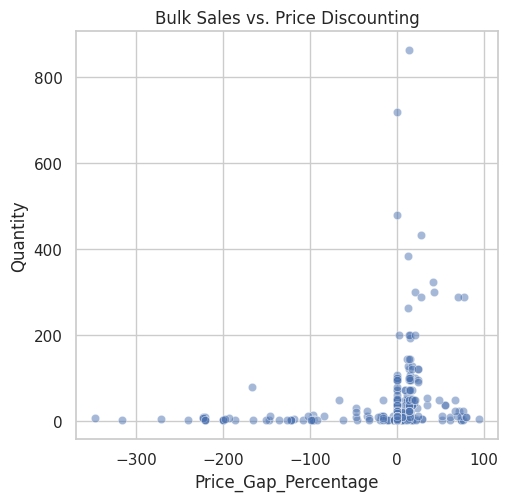

In [ ]:
# VIZ 3: Quantity vs. Price Gap (The Bulk Seller Alert)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 18))

plt.subplot(3, 2, 3)
sns.scatterplot(data=df_viz.sample(2000), x='Price_Gap_Percentage', y='Quantity', alpha=0.5)
plt.title("Bulk Sales vs. Price Discounting")

/tmp/ipython-input-1913975737.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_viz.set_index('InvoiceDate').resample('M')['Price_Gap_Percentage'].mean().plot()


Text(0.5, 1.0, 'Monthly Trend of Market Price Instability')

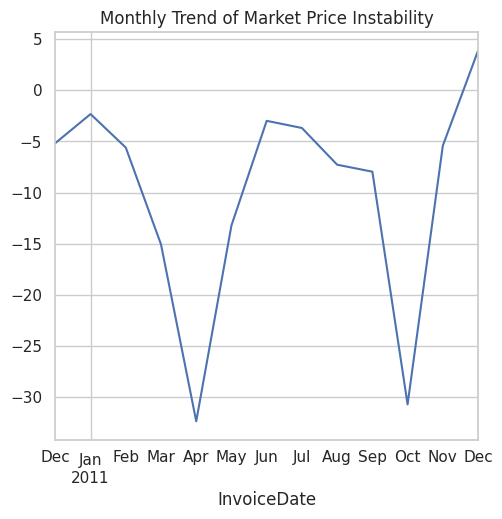

In [ ]:
# VIZ 4: Monthly Price Instability (Are certain times riskier?)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 18))

plt.subplot(3, 2, 4)
df_viz['InvoiceDate'] = pd.to_datetime(df_viz['InvoiceDate'])
df_viz.set_index('InvoiceDate').resample('M')['Price_Gap_Percentage'].mean().plot()
plt.title("Monthly Trend of Market Price Instability")

Text(0.5, 1.0, 'Top Products by Estimated Revenue Loss')

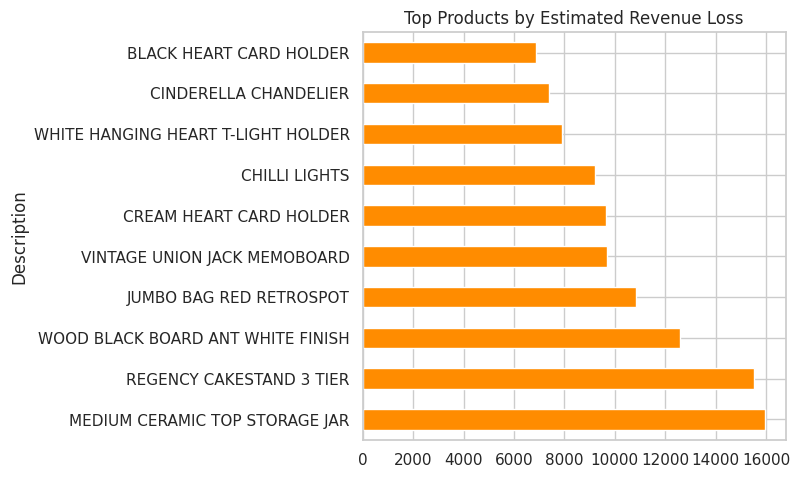

In [ ]:
# VIZ 5: Top 10 Flagged Products (The Grey Market 'Heroes')
sns.set(style="whitegrid")
plt.figure(figsize=(12, 18))
plt.subplot(3, 2, 5)
product_risk = df_viz.groupby('Description')['Revenue_At_Risk'].sum().sort_values(ascending=False).head(10)
product_risk.plot(kind='barh', color='darkorange')
plt.title("Top Products by Estimated Revenue Loss")